# Sieci neuronowe i deep learning - Lab 3

# MLP w Tensorflow, cz. II

## Cwiczenie 1

- Zaimportuj zbiór danych korzystając z funkcji tf.keras.datasets.mnist.load_data: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
- utwórz obiekty tf.data.Dataset (https://www.tensorflow.org/api_docs/python/tf/data/Dataset), jeden dla zbioru treningowego, drugi dla zbioru testowego, korzystając z metody from_tensor_slices
- użyj funkcji: shuffle do wymiaszania danych, batch do pogrupowania ich w paczki
- korzystając z metody take, pobierz kilka pierwszych danych, przekonwertuj do macierzy numpy i wyświetl

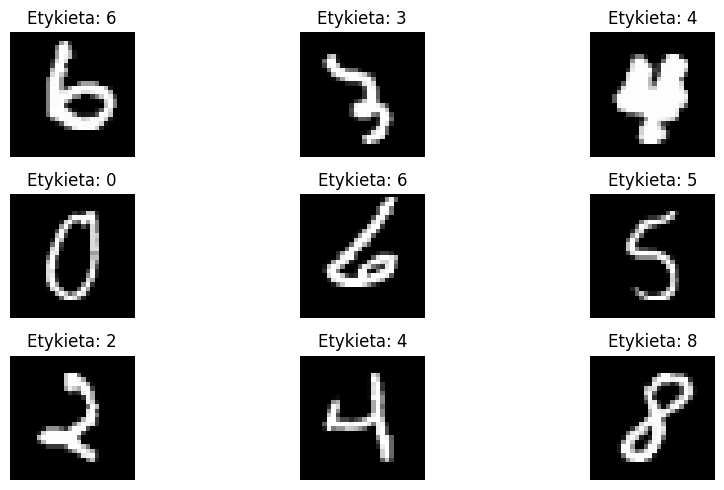

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

# Załadowanie danych MNIST
(x_train, y_train), (x_test, y_test) = load_data()

# Tworzenie obiektów tf.data.Dataset dla zbioru treningowego i testowego
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle i batchowanie danych
train_ds = train_ds.shuffle(buffer_size=10000).batch(32)
test_ds = test_ds.batch(32)

# Pobranie kilku pierwszych próbek z train_ds i konwersja do macierzy numpy
for images, labels in train_ds.take(1):  # Weźmy tylko pierwszą paczkę danych
    images_np = images.numpy()
    labels_np = labels.numpy()

# Wyświetlenie kilku przykładowych obrazów
plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images_np[i], cmap='gray')
    plt.title(f'Etykieta: {labels_np[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Ćwiczenie 2

 - Stwórz własną warstwę neuronową, implementując klasę dziedziczącą po tf.keras.layers.Layer (https://www.tensorflow.org/tutorials/customization/custom_layers). Klasa musi zawierać metodę __init__(self, parametry), build(self, input_shape), w której zdefiniujemy parametry przy pomocy metody self.add_weight, oraz metody def call(self, inputs) do zdefiniowania działania warstwy
 - Stwórz model sieci neuronowej, wykorzystujący nowy typ warstwy

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
import numpy as np

# Definicja niestandardowej warstwy
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        # Dodajemy wagę i przesunięcie (bias)
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros",
                                 trainable=True)

    def call(self, inputs):
        # Zastosowanie transformacji liniowej: y = x * W + b
        return tf.matmul(inputs, self.w) + self.b

# Tworzenie modelu sekwencyjnego wykorzystującego niestandardową warstwę
model = Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Rozwijamy obraz 28x28 na wektor
    CustomLayer(64),                       # Nasza niestandardowa warstwa z 64 jednostkami
    layers.Activation('relu'),             # Aktywacja ReLU
    layers.Dense(10, activation='softmax') # Warstwa wyjściowa z 10 klasami
])

# Kompilacja modelu
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Wyświetlenie struktury modelu
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 custom_layer (CustomLayer)  (None, 64)                50240     
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Ćwiczenie 3

- Utwórz obiekt odpowiedniej funkcji straty oraz wybranego optymalizatora
- Utwórz obiekty odpowiednich metryk, zarówno dla zbioru treningowego jak i testowego
- Stworz funkcję do trenowania train_step(x,y) z wykorzystaniem obiektu tf.GradientTape, do monitorowania gradientów. Wykorzystaj funkcję "gradient" tego obiektu do wyznaczenia gradientów funkcji straty względem parametrów modelu (model.trainable_variables) oraz metodę "apply_gradients" optymalizatora do modyfikacji tych parametrów. Opatrz funkcję dekoratorem @tf.function
- Utwórz podobną funkcję dla kroku testowania modelu

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Definicja modelu z warstwą Flatten
class SimpleModel(Model):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.flatten = layers.Flatten()  # Dodajemy warstwę Flatten
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(10, activation='softmax')  # Warstwa wyjściowa dla klasyfikacji

    def call(self, inputs):
        x = self.flatten(inputs)  # Spłaszczenie wejścia
        x = self.dense1(x)
        return self.dense2(x)

# Utwórz obiekt funkcji straty i optymalizatora
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  # 'from_logits=False' ponieważ używamy softmax
optimizer = tf.keras.optimizers.Adam()

# Utwórz obiekty metryk
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Funkcja do trenowania modelu (jeden krok)
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Obliczamy wyjście modelu i stratę
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)

    # Obliczamy gradienty
    gradients = tape.gradient(loss, model.trainable_variables)

    # Aktualizujemy wagi modelu
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Aktualizujemy metrykę dokładności dla treningu
    train_acc_metric.update_state(y, y_pred)

    return loss

# Funkcja do testowania modelu (jeden krok)
@tf.function
def test_step(x, y):
    # Obliczamy wyjście modelu
    y_pred = model(x, training=False)
    loss = loss_fn(y, y_pred)

    # Aktualizujemy metrykę dokładności dla testu
    test_acc_metric.update_state(y, y_pred)

    return loss

# Przykładowe dane
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Przekształcamy dane w kształt [batch_size, 28, 28, 1] (dodajemy wymiar kanału)
x_train = x_train[..., tf.newaxis]  # Dodanie wymiaru kanału
x_test = x_test[..., tf.newaxis]    # Dodanie wymiaru kanału

# Normalizacja danych wejściowych do zakresu [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Tworzymy model
model = SimpleModel()

# Tworzymy Dataset dla treningu i testu
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Trening - 1 epoka
for epoch in range(1):
    print("Start training")
    for step, (x_batch, y_batch) in enumerate(train_ds):
        loss = train_step(x_batch, y_batch)
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}, Train Accuracy: {train_acc_metric.result().numpy()}")

    # Wyświetlamy dokładność treningową po epokach
    print(f"End of epoch {epoch}, Training Accuracy: {train_acc_metric.result().numpy()}")

# Testowanie - 1 epoka
for epoch in range(1):
    print("Start testing")
    for step, (x_batch, y_batch) in enumerate(test_ds):
        loss = test_step(x_batch, y_batch)
        if step % 100 == 0:
            print(f"Step {step}, Test Loss: {loss.numpy()}, Test Accuracy: {test_acc_metric.result().numpy()}")

    # Wyświetlamy dokładność testową po epokach
    print(f"End of epoch {epoch}, Test Accuracy: {test_acc_metric.result().numpy()}")


Start training
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\GIGABYTE\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_130896\1823440784.py", line 76, in <module>
    loss = train_step(x_batch, y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GIGABYTE\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\GIGABYTE\AppData\Local\Temp\__autograph_generated_file8xw7uc2i.py", line 12, in tf__train_step
    loss = ag__.converted_call(ag__.ld(loss_fn), (ag__.ld(y), ag__.ld(y_pred)), None, fscope)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GIGABYTE\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 143, in

In [28]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [42]:
# Trening - 1 epoka
for epoch in range(1):
    print("Start training")
    for step, (x_batch, y_batch) in enumerate(train_ds):
        loss = train_step(x_batch, y_batch)
        if step % 100 == 0:
            # , Train Accuracy: {train_acc_metric.result().numpy()}, Loss: {loss}
            print(f"Step {step}")

    # # Wyświetlamy dokładność treningową po epokach
    # print(f"End of epoch {epoch}, Training Accuracy: {train_acc_metric.result().numpy()}")

Start training
(32, 28, 28, 10)
(32,)
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\GIGABYTE\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_130896\2561875056.py", line 5, in <module>
    loss = train_step(x_batch, y_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GIGABYTE\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\GIGABYTE\AppData\Local\Temp\__autograph_generated_fileth6bz7v8.py", line 14, in tf__train_step
    loss = ag__.converted_call(ag__.ld(loss_fn), (ag__.ld(y), ag__.ld(y_pred)), None, fscope)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GIGABYTE\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 143, in 

In [ ]:
# Testowanie - 1 epoka
for epoch in range(1):
    print("Start testing")
    for step, (x_batch, y_batch) in enumerate(test_ds):
        loss = test_step(x_batch, y_batch)
        if step % 100 == 0:
            print(f"Step {step}, Test Loss: {loss.numpy()}, Test Accuracy: {test_acc_metric.result().numpy()}")

    # Wyświetlamy dokładność testową po epokach
    print(f"End of epoch {epoch}, Test Accuracy: {test_acc_metric.result().numpy()}")

## Ćwiczenie 4

 - Zaimplementuj główną pętlę uczenia modelu dla zadanej liczby epok. Na starcie każdej epoki zresetuj ustawienia obiektów metryk (metodą reset_state), następnie wykonaj kroki uczenia na batchu ze zbioru treningowego oraz testowania na batchu ze zbioru testowego (wykorzystaj zbiory z ćwiczenia nr 1), oraz wyświetl lub zapisz do listy wyniki funkcji straty i dokładności

In [ ]:
for epoch in range(EPOCHS):
    ###################

# OPTYMALIZACJA HIPERPARAMETRÓW

## Ćwiczenie 5

- zaimportuj pakiet keras-tuner 
- Utwórz klasę dziedziczącą po klasie kt.HyperModel (https://keras.io/api/keras_tuner/hypermodels/), której metodą jest metoda def build(self, hp), zwracająca model generowany (i skompilowany) z wykorzystaniem frameworku Keras. parametr "hp" pozwala na definiowanie przedziałów poszukiwań parametrów modelu (np. liczby neuronów w warstwie)
- Utwórz obiekt tunera (np. kt.RandomSearch, https://keras.io/api/keras_tuner/tuners/) 
- Naucz model i znajdź optymalne wartości hiperparametrów metodą tuner.search (przyjmuje takie same parametry jak metoda "fit" przy trenowaniu modeli)


In [ ]:
import keras_tuner as kt

class .....(kt.HyperModel):
    def build(self, hp):
    model = ####################
    model.compile(#########)
    return model

tuner = kt.RandomSearch(nazwa klasy(),
    objective='val_loss',
    max_trials=##)
